In [1]:
# !pip install tensorflow -q

In [2]:
# !pip install matplotlib -q

In [3]:
# !pip install pandas -q

In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import matplotlib.pyplot as plt

### Loading the Dataset

In [6]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_train = 'C:/Users/admin/Desktop/Project/Dataset/Training'

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)


Found 5712 files belonging to 4 classes.


In [7]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Desktop/Project/Dataset/Testing'

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)


Found 1311 files belonging to 4 classes.


In [8]:
import matplotlib.pyplot as plt

def show_batch(dataset, num_images=9):
    """
    Displays a batch of images from the dataset.

    Parameters:
    - dataset: The dataset from which to show images.
    - num_images: The number of images to display.
    """
    # Extract a batch of 'num_images' from the dataset
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            ax = plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(int(labels[i]))
            plt.axis("off")

In [9]:
print(ds_test.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
import os

def count_images_in_each_label(directory):
    # Initialize a dictionary to hold the count of images per label
    label_counts = {}
    
    # List all items in the directory
    for label in os.listdir(directory):
        # Construct the path to the label's directory
        label_dir = os.path.join(directory, label)
        
        # Check if the path is indeed a directory
        if os.path.isdir(label_dir):
            # Count the number of image files in the directory
            num_images = len([name for name in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, name))])
            label_counts[label] = num_images
            
    return label_counts

# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Desktop/Project/Dataset/Training'

# Get the count of images in each label
label_counts = count_images_in_each_label(directory_test)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")


Label: glioma, Number of Images: 1321
Label: meningioma, Number of Images: 1339
Label: notumor, Number of Images: 1595
Label: pituitary, Number of Images: 1457


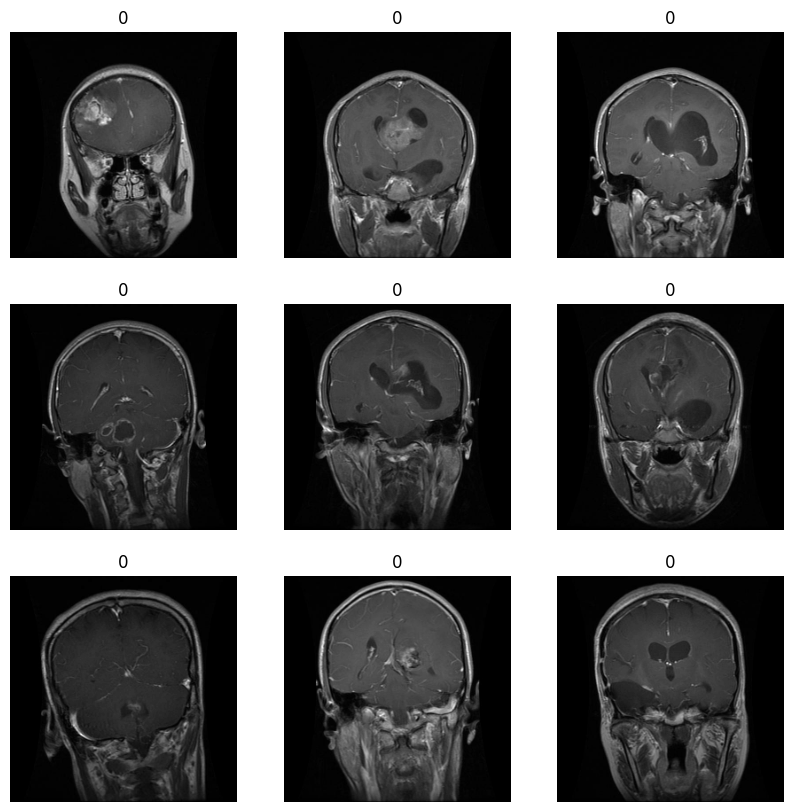

In [11]:
show_batch(ds_train, num_images=9)

### Getting dataset to a dataframe

In [12]:
import os
import pandas as pd

def dataset_directory_to_dataframe(directory):
    """
    Converts a dataset directory into a DataFrame containing file paths and class labels.

    Args:
    - directory: Path to the dataset directory. Assumes subdirectories represent class names.

    Returns:
    - df: A DataFrame with columns 'ClassPath' for file paths, 'Class' for numerical labels,
          and 'ClassName' for class names.
    """
    class_names = sorted(os.listdir(directory))  # Sorted to ensure alphabetical order
    file_paths = []
    labels = []

    # Iterate over each class directory
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        # Iterate over each image file
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if os.path.isfile(file_path):
                file_paths.append(file_path)  # Collect file paths
                labels.append(label)  # Collect corresponding labels as integers

    # Create DataFrame
    df = pd.DataFrame({'ClassPath': file_paths, 'Class': labels})
    # Map integer labels to class names
    df['ClassName'] = df['Class'].map(lambda x: class_names[x])

    return df


In [11]:
df_train = dataset_directory_to_dataframe(directory_train)
df_test = dataset_directory_to_dataframe(directory_test)

# Preprocessing

**Remove white artifacts**

In [12]:
def remove_white_text_artifacts_tf(image, label):
    """
    Removes white text artifacts from an image tensor using thresholding.

    Args:
    - image: A tensor representing an image.
    - label: The corresponding label for the image.

    Returns:
    - cleaned_image: The image tensor with white text artifacts removed.
    - label: The unchanged label.
    """
    # Convert image to grayscale if it's not already (assuming image is in [0, 1] range)
    # image_gray = tf.image.rgb_to_grayscale(image) if image.shape[-1] == 3 else image

    # Apply a threshold to get the artifacts (assumes artifacts are white)
    threshold = 250 / 255.0  # Normalize threshold to [0, 1] range
    mask = tf.where(image > threshold, 0, 1)

    # Cast the mask to float32 to match the image tensor type
    mask = tf.cast(mask, tf.float32)

    # Use the mask to remove artifacts from the image
    cleaned_image = image * mask

    return cleaned_image, label


# Applying the function to the dataset
ds_test_processed = ds_test.map(remove_white_text_artifacts_tf)


In [27]:
def load_and_preprocess_image(image_path, img_height, img_width):
    """
    Load an image from a file path and preprocess it by resizing.

    Args:
    - image_path: Path to the image file.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.

    Returns:
    - image: A TensorFlow tensor representing the loaded and resized image.
    """
    # Read the image file
    img_raw = tf.io.read_file(image_path)

    # Decode the image
    image = tf.image.decode_image(img_raw, channels=3)

    # Convert image to floating point values in the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image
    image = tf.image.resize(image, [img_height, img_width])

    return image

In [28]:
def display_image_tensor(image_tensor):
    """
    Displays an image contained in a TensorFlow tensor.

    Args:
    - image_tensor: A TensorFlow tensor representing an image.
    """
    # Convert the tensor to a numpy array
    image_numpy = image_tensor.numpy()

    # Display the image using matplotlib
    plt.imshow(image_numpy)
    plt.axis('off')  # Hide the axis
    plt.show()


# Remove Artifacts

In [29]:
import cv2
import matplotlib.pyplot as plt

def inpaint_image(image_path):
    """
    Reads an image from the specified path, applies thresholding to create a mask,
    and then inpaints the image to fill areas defined by the mask.

    Args:
    - image_path: Path to the input image.

    Returns:
    - dst: The inpainted image.
    """
    # Read the image
    img = cv2.imread(image_path)
    
    # Ensure the image was loaded (img is not None)
    if img is None:
        raise ValueError("Image not found or path is incorrect")
    
    # Convert the image to grayscale for thresholding
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to create a mask
    _, mask = cv2.threshold(gray_img, 210, 255, cv2.THRESH_BINARY)
    
    # Inpaint the original image using the mask
    dst = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
    
    return dst



In [30]:
# Use the function and provide the path to your image
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/ct-artifact-34-638.png'
inpainted_image = inpaint_image(image_path)


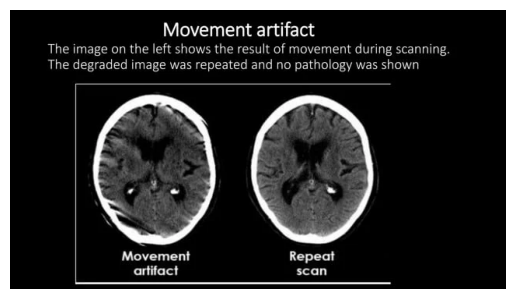

In [31]:
import matplotlib.pyplot as plt
import cv2

def display_image_from_path(image_path):
    """
    Reads and displays an image from the given path.

    Args:
    - image_path: Path to the image file.
    """
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if img is None:
        print("Failed to load image.")
        return
    
    # Convert the image from BGR (OpenCV's format) to RGB (matplotlib's format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/ct-artifact-34-638.png'
display_image_from_path(image_path)


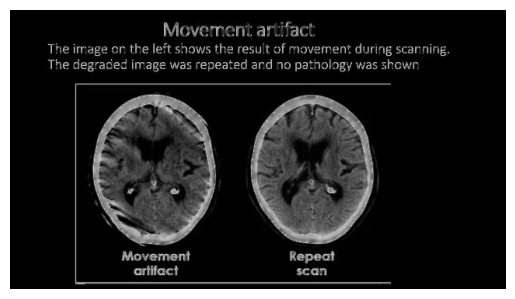

In [32]:
# Display the inpainted image using matplotlib
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()

In [33]:
# !pip install tensorflow-addons -q

In [34]:

# Example usage
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/ct-artifact-34-638.png'
img_height = 256
img_width = 256
image_tensor = load_and_preprocess_image(image_path, img_height, img_width)

# If you want to inspect the image tensor, for example, to verify its shape
print(image_tensor.shape)  # Output: (256, 256, 3)

(256, 256, 3)


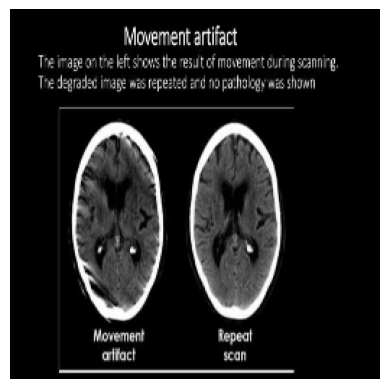

In [21]:
display_image_tensor(image_tensor)

In [22]:
image_1, label_1 = remove_white_text_artifacts_tf(image_tensor, 'none')

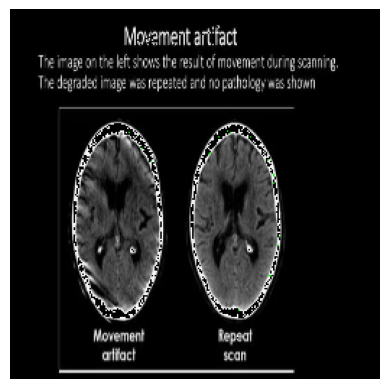

In [23]:
display_image_tensor(image_1)


In [24]:
def remove_artifacts_tf(image_tensor):
    """
    Removes light artifacts from an image tensor using thresholding.
    
    Args:
    - image_tensor: A TensorFlow tensor representing an image in grayscale.
    
    Returns:
    - cleaned_image_tensor: The image tensor with artifacts removed.
    """
    # Normalize the image tensor to [0, 1]
    image_tensor = tf.cast(image_tensor, tf.float32) / 255.0
    
    # Threshold the image to get the artifacts
    # Threshold value is normalized to [0, 1]
    threshold_value = 240 / 255.0
    thresh_image_tensor = tf.where(image_tensor > threshold_value, 0.0, 1.0)
    
    # Invert the mask to preserve the rest of the image
    mask_tensor = 1 - thresh_image_tensor
    
    # Apply the mask to the original image to remove the artifacts
    cleaned_image_tensor = image_tensor * mask_tensor
    
    # Rescale to the original range [0, 255] if needed
    cleaned_image_tensor = tf.cast(cleaned_image_tensor * 255, tf.uint8)
    
    return cleaned_image_tensor

In [25]:

# Example usage
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/CT-Image-with-artifacts.jpg'
img_height = 256
img_width = 256
image_tensor = load_and_preprocess_image(image_path, img_height, img_width)

# If you want to inspect the image tensor, for example, to verify its shape
print(image_tensor.shape)  # Output: (256, 256, 3)

(256, 256, 3)


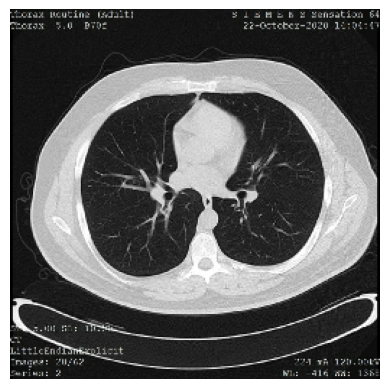

In [26]:
display_image_tensor(image_tensor)

In [27]:
image_1 = remove_artifacts_tf(image_tensor)

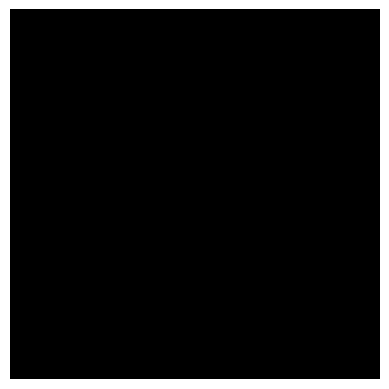

In [28]:
display_image_tensor(image_1)

**Median Filter**

In [13]:
import tensorflow as tf
import tensorflow_addons as tfa

def apply_median_filter(image, label):
    """
    Apply a median filter to an image.

    Args:
    - image: A tensor representing an image.
    - label: The corresponding label for the image.

    Returns:
    - filtered_image: The image after applying the median filter.
    - label: The unchanged label.
    """
    # Apply the median filter. The `filter_shape` parameter determines the size of the
    # window over which the median is computed. A larger value will lead to more smoothing.
    # Here, we use a 3x3 window as an example.
    filtered_image = tfa.image.median_filter2d(image, filter_shape=(3, 3))

    return filtered_image, label

# Assuming your dataset is named `ds_train`
# Apply the median filter to each image in the dataset
# ds_train_filtered = ds_train.map(apply_median_filter)


c:\Users\admin\anaconda3\envs\brain_tumor_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [35]:
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/Tr-me_0034.jpg'
image_tensor = load_and_preprocess_image(image_path, img_height, img_width)

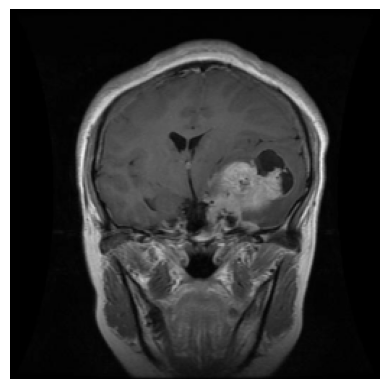

In [36]:
display_image_tensor(image_tensor)

In [37]:
image_1, label = apply_median_filter(image_tensor, 'dev-test')

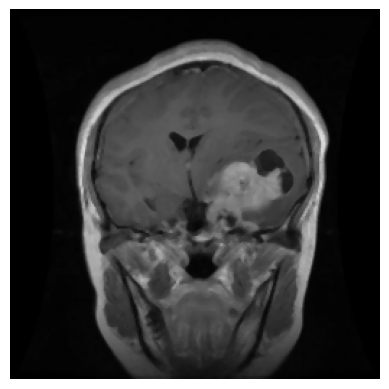

In [38]:
display_image_tensor(image_1)

In [39]:
ds_train_processed = ds_train.map(apply_median_filter)

In [40]:
type(ds_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [41]:
type(ds_train_processed)

tensorflow.python.data.ops.map_op._MapDataset

In [42]:
for images, labels in ds_train_processed.take(1):
    print("Labels:", labels.numpy())
    print("Class names:", ds_train.class_names)


Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [43]:
ds_test_processed = ds_test.map(apply_median_filter)

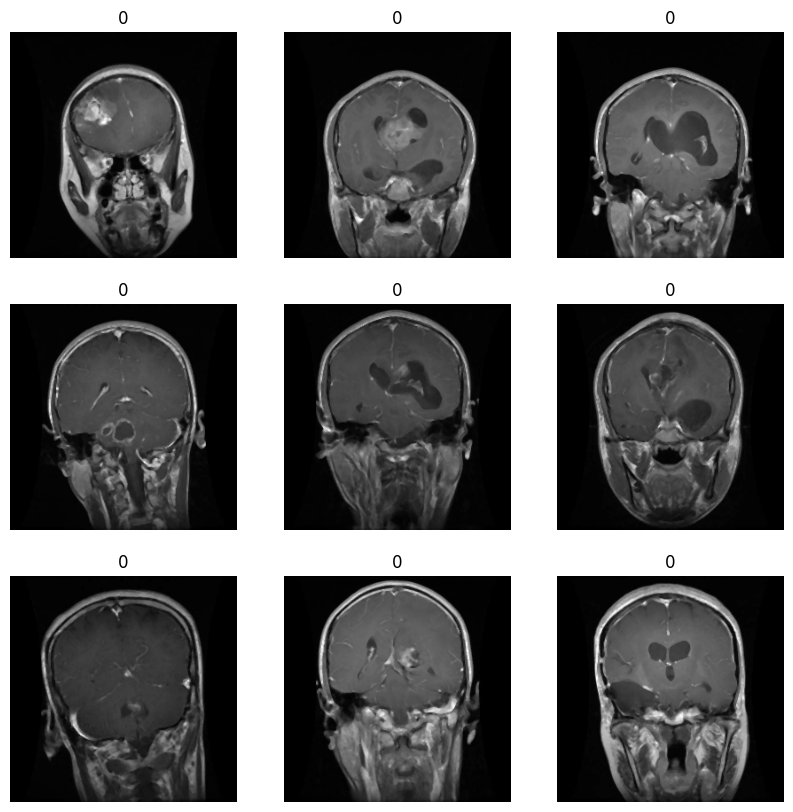

In [44]:
show_batch(ds_train_processed, num_images=9)

In [45]:
for images, labels in ds_test_processed.take(1):
    print("Labels:", labels.numpy())
    print("Class names:", ds_train.class_names)

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Image Segmentation

In [46]:
import tensorflow as tf

def segment_image(image, label):
    """
    Apply simple thresholding to segment the image.
    
    Args:
    - image: The input image tensor.
    - label: The corresponding label tensor.
    
    Returns:
    - segmented_image: The segmented image tensor.
    - label: The unchanged label tensor.
    """
    # Convert the image to grayscale if it's not already
    image_gray = tf.image.rgb_to_grayscale(image) if image.shape[-1] == 3 else image
    
    # Normalize the image tensor to [0, 1]
    image_normalized = image_gray / 255.0
    
    # Define the threshold value
    threshold = 0.5  # This is a normalized threshold since the image is normalized
    
    # Apply thresholding
    segmented_image = tf.where(image_normalized < threshold, 0.0, 1.0)
    
    # The output segmented_image will have values 0 for background and 1 for foreground
    
    return segmented_image, label



In [47]:
# Assume ds is your TensorFlow dataset that has images and labels
ds_test_segmented = ds_test.map(segment_image)
ds_train_segmented = ds_train.map(segment_image)

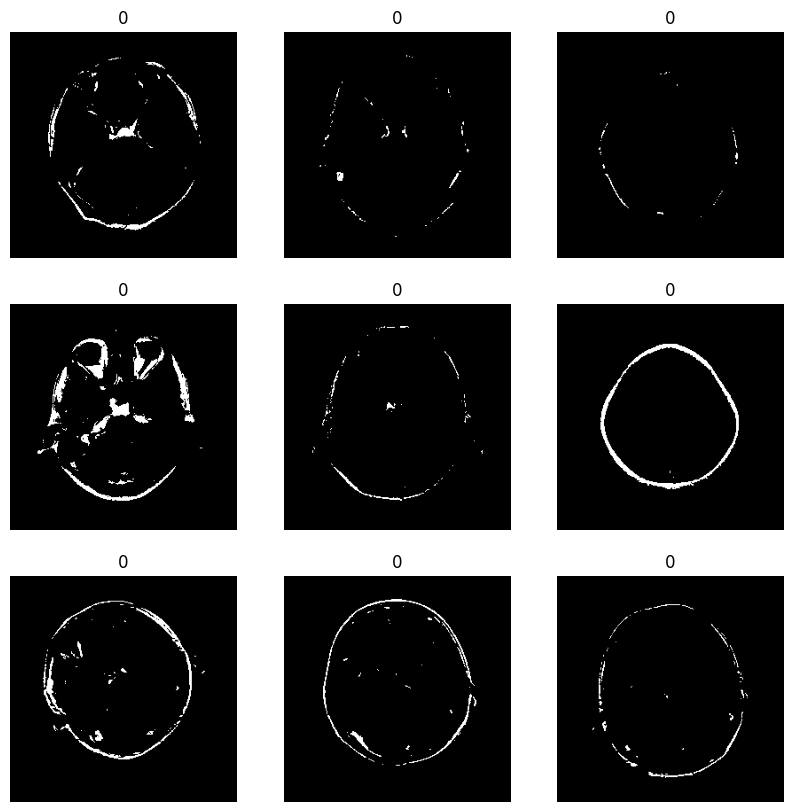

In [48]:
show_batch(ds_test_segmented, num_images=9)

In [49]:
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/Tr-me_0034.jpg'
image_tensor = load_and_preprocess_image(image_path, img_height, img_width)

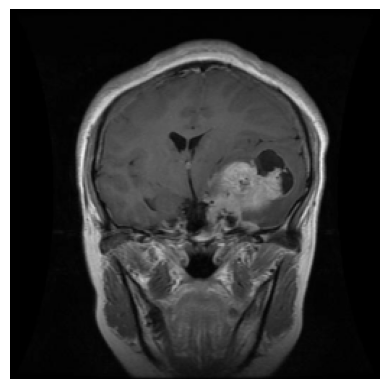

In [50]:
display_image_tensor(image_tensor)

In [51]:
image_1, label = segment_image(image_tensor, 'none')

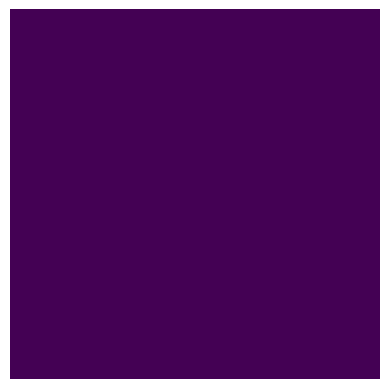

In [52]:
display_image_tensor(image_1)

In [53]:
type(ds_test_segmented)

tensorflow.python.data.ops.map_op._MapDataset

# DWT

In [54]:
# !pip install PyWavelets -q


In [55]:
import pywt
import numpy as np
import tensorflow as tf

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def simple_dwt(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # Normalize the image
    image /= 255.0

    # Define the Haar wavelet filters
    lp_filter = np.array([1, 1]) / np.sqrt(2)  # Low-pass filter
    hp_filter = np.array([1, -1]) / np.sqrt(2)  # High-pass filter

    # Convolve and downsample for each direction
    # Horizontal filtering
    low_pass = np.array([np.convolve(row, lp_filter, mode='valid')[::2] for row in image])
    high_pass = np.array([np.convolve(row, hp_filter, mode='valid')[::2] for row in image])

    # Vertical filtering
    LL = np.array([np.convolve(low_pass[:, col], lp_filter, mode='valid')[::2] for col in range(low_pass.shape[1])]).T
    LH = np.array([np.convolve(low_pass[:, col], hp_filter, mode='valid')[::2] for col in range(low_pass.shape[1])]).T
    HL = np.array([np.convolve(high_pass[:, col], lp_filter, mode='valid')[::2] for col in range(high_pass.shape[1])]).T
    HH = np.array([np.convolve(high_pass[:, col], hp_filter, mode='valid')[::2] for col in range(high_pass.shape[1])]).T

    return LL, LH, HL, HH

def visualize_dwt(dwt_components):
    LL, LH, HL, HH = dwt_components

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(LL, cmap='gray')
    plt.title("LL - Approximation")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(LH, cmap='gray')
    plt.title("LH - Horizontal Detail")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(HL, cmap='gray')
    plt.title("HL - Vertical Detail")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(HH, cmap='gray')
    plt.title("HH - Diagonal Detail")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [57]:
def dwt_transform(image):
    # Convert the tensor to a numpy array
    image_np = image.numpy()
    
    # Ensure image is 2D
    if image_np.ndim == 3 and image_np.shape[-1] == 1:
        image_np = image_np.squeeze(-1)
    
    # Perform the 2D Discrete Wavelet Transform
    coeffs = pywt.dwt2(image_np, 'db1')
    # Extract approximation coefficients
    cA = coeffs[0]
    
    return cA

def apply_dwt_to_dataset(image, label):
    # Apply the DWT transform to the image using tf.py_function
    cA = tf.py_function(dwt_transform, [image], tf.float32)
    
    # The change in shape due to DWT needs to be explicitly set
    # cA will have half the size of the image for 'db1'
    new_shape = (image.shape[0] // 2, image.shape[1] // 2, 1)
    cA.set_shape(new_shape)
    
    return cA, label

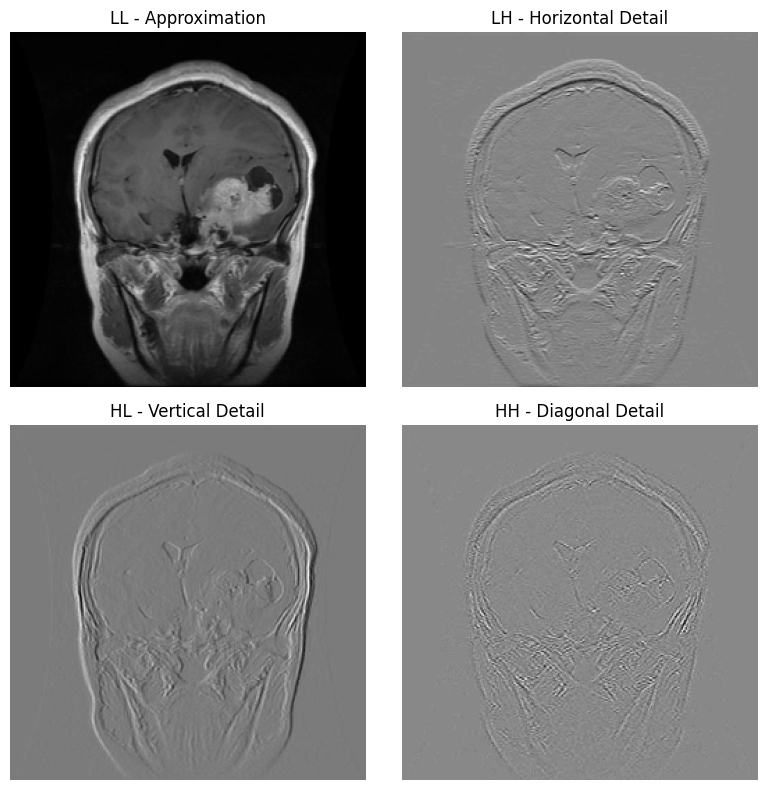

In [58]:
image_path = 'C:/Users/admin/Desktop/Project/project-tumor-detection/research/Tr-me_0034.jpg'
dwt_components = simple_dwt(image_path)
visualize_dwt(dwt_components)


In [59]:
dwt_components[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
def dwt_transform(image):
    # Convert the image tensor to a numpy array
    image_np = image.numpy()
    # Perform 2D Discrete Wavelet Transform
    coeffs = pywt.dwt2(image_np, 'db1')
    # Extract approximation coefficients
    cA, (cH, cV, cD) = coeffs
    # Stack approximation and details coefficients into a single numpy array
    dwt_result = np.stack((cA, cH, cV, cD), axis=-1)
    return dwt_result

def apply_dwt_to_dataset(image, label):
    # Apply dwt_transform and use tf.py_function to allow non-TensorFlow functions
    dwt_image = tf.py_function(func=dwt_transform, inp=[image], Tout=tf.float64)
    # print(type(dwt_image))
    # Infer the shape of the DWT output and set it
    dwt_shape = (image.shape[0] // 2, image.shape[1] // 2, 4) if image.shape[0] is not None else (None, None, 4)
    dwt_image.set_shape(dwt_shape)
    return dwt_image, label

In [61]:
# Assuming ds is your TensorFlow dataset that has images and labels
ds_test_dwt = ds_test_segmented.map(apply_dwt_to_dataset)

In [62]:
for images, labels in ds_test_dwt.take(1):
    print("Labels:", labels.numpy())
    print("Class names:", ds_train.class_names)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes at component 0: expected [?,?,4] but got [32,256,128,1,4]. [Op:IteratorGetNext] name: 

# KNN

In [63]:
import numpy as np

def dataset_to_numpy(ds):
    features, labels = [], []
    for feature_batch, label_batch in ds:
        features.extend(feature_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = dataset_to_numpy(ds_train_segmented)
X_test, y_test = dataset_to_numpy(ds_test_segmented)


In [64]:
# !pip install scikit-learn -q

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [66]:
# Reshape the image data to 2D (number_of_samples, number_of_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Now you can apply StandardScaler to the reshaped data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

In [67]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with an appropriate value of k
knn = KNeighborsClassifier(n_neighbors=5)  # Example with k=5

# Train the classifier using the flattened and scaled data
knn.fit(X_train_scaled, y_train)

# Make predictions
predictions = knn.predict(X_test_scaled)

# Evaluate the model as previously described

In [68]:
from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.5751334858886347
              precision    recall  f1-score   support

           0       0.48      0.36      0.41       300
           1       0.89      0.31      0.46       306
           2       0.50      0.97      0.65       405
           3       0.84      0.53      0.65       300

    accuracy                           0.58      1311
   macro avg       0.68      0.54      0.55      1311
weighted avg       0.66      0.58      0.55      1311



In [76]:
! pip install joblib -q

In [77]:
from joblib import dump

dump(knn, 'my_knn_model.joblib')


['my_knn_model.joblib']

# SVM

In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score

# # Assuming X_train_scaled, y_train are your training data and labels
# svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example configuration
# svm_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# predictions = svm_classifier.predict(X_test_scaled)

# # Evaluate the model
# print(f"Accuracy: {accuracy_score(y_test, predictions)}")
# print(classification_report(y_test, predictions))

In [63]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#     'kernel': ['rbf']
# }

# # Create a GridSearchCV object
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5)

# # Fit the model to the training data
# grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
# # Print out the best parameters
# print("Best parameters found: ", grid.best_params_)

In [ ]:
# from sklearn.metrics import classification_report, accuracy_score

# # Use the best estimator found by the grid search
# best_svc = grid.best_estimator_

# # Make predictions
# predictions = best_svc.predict(X_test_scaled)

# # Evaluate the model
# print(f"Accuracy: {accuracy_score(y_test, predictions)}")
# print(classification_report(y_test, predictions))


# ANN

In [69]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

def create_mlp_model(input_shape, hidden_layers, output_units, learning_rate=0.3, momentum=0.2):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(output_units, activation='softmax'))  # Output layer
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [70]:
tf.random.set_seed(0)  # Set seed

# Assuming your input data is of shape (img_height, img_width, channels)
# Adjust this according to your actual data shape
input_shape = (img_height, img_width, 1)  
hidden_layers = [64, 64]  
output_units = len(ds_train.class_names) 

model = create_mlp_model(input_shape, hidden_layers, output_units)


In [71]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)


In [72]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stopping], verbose=1)

Epoch 1/100
58/58 [==============================] - 4s 56ms/step - loss: 2.5173 - accuracy: 0.3708 - val_loss: 1.2974 - val_accuracy: 0.3959
Epoch 2/100
58/58 [==============================] - 4s 61ms/step - loss: 1.1744 - accuracy: 0.4979 - val_loss: 1.0366 - val_accuracy: 0.5492
Epoch 3/100
58/58 [==============================] - 4s 62ms/step - loss: 0.8737 - accuracy: 0.6266 - val_loss: 1.6800 - val_accuracy: 0.5919
Epoch 4/100
58/58 [==============================] - 4s 63ms/step - loss: 0.8571 - accuracy: 0.6546 - val_loss: 1.0631 - val_accuracy: 0.6804
Epoch 5/100
58/58 [==============================] - 3s 48ms/step - loss: 0.5929 - accuracy: 0.7577 - val_loss: 0.8117 - val_accuracy: 0.7033
Epoch 6/100
58/58 [==============================] - 3s 45ms/step - loss: 0.5067 - accuracy: 0.7815 - val_loss: 0.7384 - val_accuracy: 0.7323
Epoch 7/100
58/58 [==============================] - 2s 41ms/step - loss: 0.5123 - accuracy: 0.7931 - val_loss: 1.2667 - val_accuracy: 0.5591
Epoch 

In [73]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


41/41 - 0s - loss: 0.8644 - accuracy: 0.7536 - 397ms/epoch - 10ms/step
Test accuracy: 0.7536231875419617, Test loss: 0.8644352555274963


In [74]:
model.save('my_mlp_model') 

INFO:tensorflow:Assets written to: my_mlp_model\assets


INFO:tensorflow:Assets written to: my_mlp_model\assets


#